# Model Training

<font color='green'>Notebook used to train and display the defined models.</font>

---
### 1. Data Retrieval and Sanitization
- Training and Validation Set Retrieval
- Text Sanitization
- Label Indexing
---

### 2. Feature Engineering
- Sequence Vectorization
1. Tokenize Text
2. Texts to Sequences
3. Pad Sequences

- Embeddings
1. Load Pre-Trained Embeddings
2. Embedding matrix
---
### 3. Model Definitions
- Decomposable Attention Model by Perikh et al. (DAM)
- Decomposable Attention Model with Intra-Sentence Attention (DAM-INTRA)
- Decomposable Attention Model with BiLSTM (DAM-BiLSTM)
- Decomposable Attention Model with BiGRU (DAM-BiGRU)
---
### 4. Model Training
- Decomposable Attention Model by Perikh et al. (DAM)
- Decomposable Attention Model with Intra-Sentence Attention (DAM-INTRA)
- Decomposable Attention Model with BiLSTM (DAM-BiLSTM)
- Decomposable Attention Model with BiGRU (DAM-BiGRU)

In [82]:
# For File Handling
import csv
import os

# For Data
import pandas as pd
import numpy as np

# For Processing
import re
import nltk
import string

# For Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# For Word Embeddings
import gensim
import gensim.downloader as gensim_api

# For Deep Learning
import tensorflow as tf
from tensorflow.keras import Model, models, layers, preprocessing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# For Model Visualisation
import keras
import pydotplus
import graphviz
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot

# Miscellaneous 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data directories
dataset_dir = "dataset"
saved_models_dir = "saved-models"
model_representations_dir = "model-representations"

# SNLI dataset files
snli_train_file = "dataset/snli_1.0_train.txt"
snli_val_file = "dataset/snli_1.0_dev.txt"
snli_test_file = "dataset/snli_1.0_test.txt"

# Saved Model files
dam_save_file = "saved-models/dam_weights.hdf5"
dam_intra_save_file = "saved-models/dam_intra_weights.hdf5"
dam_bilstm_save_file = "saved-models/dam_bilstm_weights.hdf5"
dam_bigru_save_file = "saved-models/dam_bigru_weights.hdf5"

In [3]:
# Since tensorflow gpu is being used
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

# 1. Data Retrieval and Sanitization

In [4]:
try:
    assert os.path.exists(dataset_dir)
    assert os.path.exists(snli_train_file)
    assert os.path.exists(snli_val_file)
except:
    print("Assertion failed: Run dataset-utils.ipynb to initialise dataset files")

### Training and Validation Set Retrieval

In [5]:
def get_data(data_file):
    
    if os.path.exists(data_file):
        with open(data_file,"r") as open_file:
            csv_file = csv.DictReader(open_file, delimiter='\t')

            premise_sentences = []
            hypothesis_sentences = []
            gold_labels = []

            for row in csv_file:
                
                # Skip rows if label is not definite
                if row["gold_label"] != "-":
                    premise_sentences.append(row["sentence1"])
                    hypothesis_sentences.append(row["sentence2"])
                    gold_labels.append(row["gold_label"])

            return premise_sentences, hypothesis_sentences, gold_labels


train_dict = dict()
val_dict = dict()

# Store data in respective dictionaries
train_dict['premise'], train_dict['hypothesis'], train_dict['label'] = get_data(snli_train_file)
val_dict['premise'], val_dict['hypothesis'], val_dict['label'] = get_data(snli_val_file)

# Create Pandas dataframes for each set
train_df = pd.DataFrame(train_dict)
val_df = pd.DataFrame(val_dict)

### Text Sanitization

In [6]:
def sanitize_text(text):
    # Remove punctuation and lower case
    sanitized_text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    return sanitized_text

train_df["premise_clean"] = train_df["premise"].apply(lambda x: sanitize_text(x))
train_df["hypothesis_clean"] = train_df["hypothesis"].apply(lambda x: sanitize_text(x))

val_df["premise_clean"] = val_df["premise"].apply(lambda x: sanitize_text(x))
val_df["hypothesis_clean"] = val_df["hypothesis"].apply(lambda x: sanitize_text(x))

### Label Indexing

In [7]:
label_index = {
    "entailment":0,
    "neutral":1,
    "contradiction":2,
}

def indexify_label(label):
    return label_index[label]

train_df["label_index"] = train_df["label"].apply(lambda x: indexify_label(x))
val_df["label_index"] = val_df["label"].apply(lambda x: indexify_label(x))

# 2. Feature Engineering

### Sequence Vectorization

#### 1. Tokenize Text

In [8]:
# Tokenize text
all_train_text = list(train_df['premise_clean']) + list(train_df['hypothesis_clean']) + list(val_df['premise_clean']) + list(val_df['hypothesis_clean'])

tokenizer = preprocessing.text.Tokenizer(oov_token="OOV")
tokenizer.fit_on_texts(all_train_text)
word_index = tokenizer.word_index

#### 2. Text To Sequences

In [9]:
def texts_to_sequences(texts):
    return tokenizer.texts_to_sequences(texts)

train_sequence_dict = dict()
val_sequence_dict = dict()

# Create Train sequences
train_sequence_dict['premise'] = texts_to_sequences(train_df['premise_clean'])
train_sequence_dict['hypothesis'] = texts_to_sequences(train_df['hypothesis_clean'])

# Create Val sequences
val_sequence_dict['premise'] = texts_to_sequences(val_df['premise_clean'])
val_sequence_dict['hypothesis'] = texts_to_sequences(val_df['hypothesis_clean'])

#### 3. Pad Sequences

In [10]:
# Max sequence length set to 50 instead of max sentence length (78) to avoid sparsity in vectors
# Full explanation on data-visualizer.ipynb
max_sequence_len = 50

In [11]:
def pad_sequences(sequences, maxlen):
    '''
        padding="post": add zeros at the end of the sequence to make the samples in the same size.
        maxlen=max_sequence_len: this input defines the maximum number of words in sequences.
        truncating="post" when a sentence exceeds the number of maximum words, drop the last words in the sentence.
    '''
    return preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen, padding="post", truncating="post")

# Pad Train Sequences
train_sequence_dict['premise_padded'] = pad_sequences(train_sequence_dict['premise'], maxlen=max_sequence_len)
train_sequence_dict['hypothesis_padded'] = pad_sequences(train_sequence_dict['hypothesis'], maxlen=max_sequence_len)

# Pad Val Sequences
val_sequence_dict['premise_padded'] = pad_sequences(val_sequence_dict['premise'], maxlen=max_sequence_len)
val_sequence_dict['hypothesis_padded'] = pad_sequences(val_sequence_dict['hypothesis'], maxlen=max_sequence_len)

### Embeddings

#### 1. Load Pre-Trained Embeddings
To ensure the best results, a pre-trained model for embedding was used. Alternatively, a model could have also been trained using the SNLI dataset. However, by using the word2vec-google-news-300 model which contains information on about 100 billion words, more accurate vector contexts.

Link to gensim-data: https://github.com/RaRe-Technologies/gensim-data

In [12]:
embedding_model = gensim_api.load("word2vec-google-news-300")

#### 2. Embedding Matrix

In [13]:
# 300 vector size since using word2vec-google-news-300
vector_size = 300

# Length of vocabulary is added a 1 to account for the OOV token
len_vocab = len(word_index)+1

# Create embedding matrix (length of vocabulary x vector size)
embeddings = np.zeros((len_vocab, vector_size))

for word,idx in word_index.items():
    # Update embeddings with pre-trained vectors if word exists
    try:
        embeddings[idx] = embedding_model[word]
        
    # If word does not exist, skip
    except:
        pass

# 3. Model Definitions

In [14]:
# If visual models directory doesn't exist, create it
if not os.path.exists(model_representations_dir):
    os.mkdir(model_representations_dir)

In [15]:
# Function to return an embedding layer
def embedding_layer(name, embeddings, num_nodes=16):
    return models.Sequential(
        [
            # Embedding Layer
            layers.Embedding(
                embeddings.shape[0],
                embeddings.shape[1],
                input_length=max_sequence_len,
                weights=[embeddings],
                trainable=False,
            ),
        ], name=name)


# Function to return a feed-forward layer
def feed_forward_layer(name, num_nodes=200, activation="relu", dropout_rate=0):
    return models.Sequential(
        [
            layers.Dense(num_nodes, activation=activation),
            layers.Dropout(dropout_rate),
            layers.Dense(num_nodes, activation=activation),
            layers.Dropout(dropout_rate),
        ], name=name)


# Function to return BiLSTM layer
def bilstm_layer(name, num_nodes=200, activation="relu", dropout_rate=0):
    return layers.Bidirectional(
            layers.LSTM(num_nodes, return_sequences=True, dropout=dropout_rate, activation=activation),
        name=name)


# Function to return a BiGRU layer
def bigru_layer(name, num_nodes=200, activation="relu", dropout_rate=0):
    return layers.Bidirectional(
            layers.GRU(num_nodes, return_sequences=True, dropout=dropout_rate, activation=activation),
        name=name)


# Function to carry out normalisation for soft-alignment
def normalizer(axis):
    def _normalize(vector_similarities):
        exp_weights = K.exp(vector_similarities)
        sum_weights = K.sum(exp_weights, axis=axis, keepdims=True)
        return exp_weights / sum_weights

    return _normalize


# Function to return distance-sensitive bias terms for intra-sentence attention
def distance_terms(input_shape):
    
    time_steps = input_shape[1]
    distance_terms = np.zeros(shape=(time_steps, time_steps))
    for i in range(time_steps):
        for j in range(time_steps):
            distance_terms[i][j] = min(i-j, 10)
    
    #return K.variable(distance_terms)
    return distance_terms
        
    
# Function to carry out normalisation for intra-sentence attention
def intra_normalizer(axis, distance_terms):
    def _normalize(f_i_j):
        exp_weights = K.exp(f_i_j + distance_terms)
        sum_weights = K.sum(exp_weights, axis=axis, keepdims=True)
        return exp_weights / sum_weights

    return _normalize


# Function to sum and return an aggregated vector
def aggregater(x):
    return K.sum(x, axis=1, keepdims=False)

### Decomposable Attention Model by Perikh et al. (DAM)

In [16]:
# Function to combine layers together and return the final dam model
def build_dam_model(num_nodes, intra_sentence_attention=False):
    
    # Input Layer
    x1 = layers.Input(shape=(max_sequence_len,), name="Input_x1")
    x2 = layers.Input(shape=(max_sequence_len,), name="Input_x2")
    
    # Embedding Layer
    embedding = embedding_layer("Embedding", embeddings)
    e1 = embedding(x1)
    e2 = embedding(x2)
    
    input_a = e1
    input_b = e2
    
    if intra_sentence_attention:
        # Intra-Sentence Attention
        feedforward_intra = feed_forward_layer("FF_Intra", num_nodes, dropout_rate= 0.1)
        intra_a_i = feedforward_intra(e1)
        intra_a_j = feedforward_intra(e2)

        f_i_j = layers.dot([intra_a_i, layers.Permute((2,1))(intra_a_j)], axes=(2,1), name="Intra-Attention")

        # -> Distance Sensitive bias terms
        d_i_j = distance_terms(e1.shape)

        # -> Self-Aligned Phrases
        norm_i = layers.Lambda(intra_normalizer(1, d_i_j), name="Normalise_Similarities_i")(f_i_j)
        norm_j = layers.Lambda(intra_normalizer(2, d_i_j), name="Normalise_Similarities_j")(f_i_j)
        self_aligned_ai = layers.dot([norm_i, e1], axes=1, name="Self-Align_a_i")
        self_aligned_bi = layers.dot([norm_j, e2], axes=1, name="Self-Align_b_i")

        input_a = layers.concatenate([e1, self_aligned_ai], name="Concat_embedding_and_self-aligned_a")
        input_b = layers.concatenate([e2, self_aligned_bi], name="Concat_embedding_and_self-aligned_b")
        
    # Attend
    # -> Pass each word through a FFN with RelU activations to yield a non-linear transformation.
    feedforward_F = feed_forward_layer("FF_F", num_nodes, dropout_rate= 0.1)
    x1_nonlinear = feedforward_F(input_a)
    x2_nonlinear = feedforward_F(input_b)
    
    # -> Compute pairwise word similarity between every word in x1 compared to every word in x2, and vice versa.
    vector_similarities = layers.dot([x1_nonlinear, layers.Permute((2,1))(x2_nonlinear)], axes=(2,1), name="Pairwise_Similarity")
    
    # -> Compute Soft-Attention
    norm_similarities_x1 = layers.Lambda(normalizer(1), name="Normalise_Similarities_x1")(vector_similarities)
    norm_similarities_x2 = layers.Lambda(normalizer(2), name="Normalise_Similarities_x2")(vector_similarities)
    alpha = layers.dot([norm_similarities_x2, e1], axes=1, name="Alpha")
    beta = layers.dot([norm_similarities_x1, e2], axes=1, name="Beta")
        
    # Compare
    feedforward_G = feed_forward_layer("FF_G", num_nodes, dropout_rate= 0.1)
    comp1 = layers.concatenate([e1, beta], name="Concat_x1_beta")
    comp2 = layers.concatenate([e2, alpha], name="Concat_x2_alpha")
    
    v1 = feedforward_G(comp1)
    v2 = feedforward_G(comp2)
    
    # Aggregate
    v1_sum = layers.Lambda(aggregater, name="Aggregate_v1")(v1)
    v2_sum = layers.Lambda(aggregater, name="Aggregate_v2")(v2)
    concat = layers.concatenate([v1_sum, v2_sum], name="Concat_v1_v2")
    
    # Output Layer
    feedforward_H = feed_forward_layer("FF_H", num_nodes, dropout_rate= 0.1)
    y = feedforward_H(concat)
    y = layers.Dense(3, activation="softmax", name="Output")(y)
        
    model = Model(inputs=[x1, x2], outputs=y)
    
    model.compile(
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
        optimizer=Adam(lr=0.0005),
    )

    return model

In [83]:
dam_model = build_dam_model(200)
dam_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_x1 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
Input_x2 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
Embedding (Sequential)          (None, 50, 300)      10873200    Input_x1[0][0]                   
                                                                 Input_x2[0][0]                   
__________________________________________________________________________________________________
FF_F (Sequential)               (None, 50, 200)      100400      Embedding[1][0]           

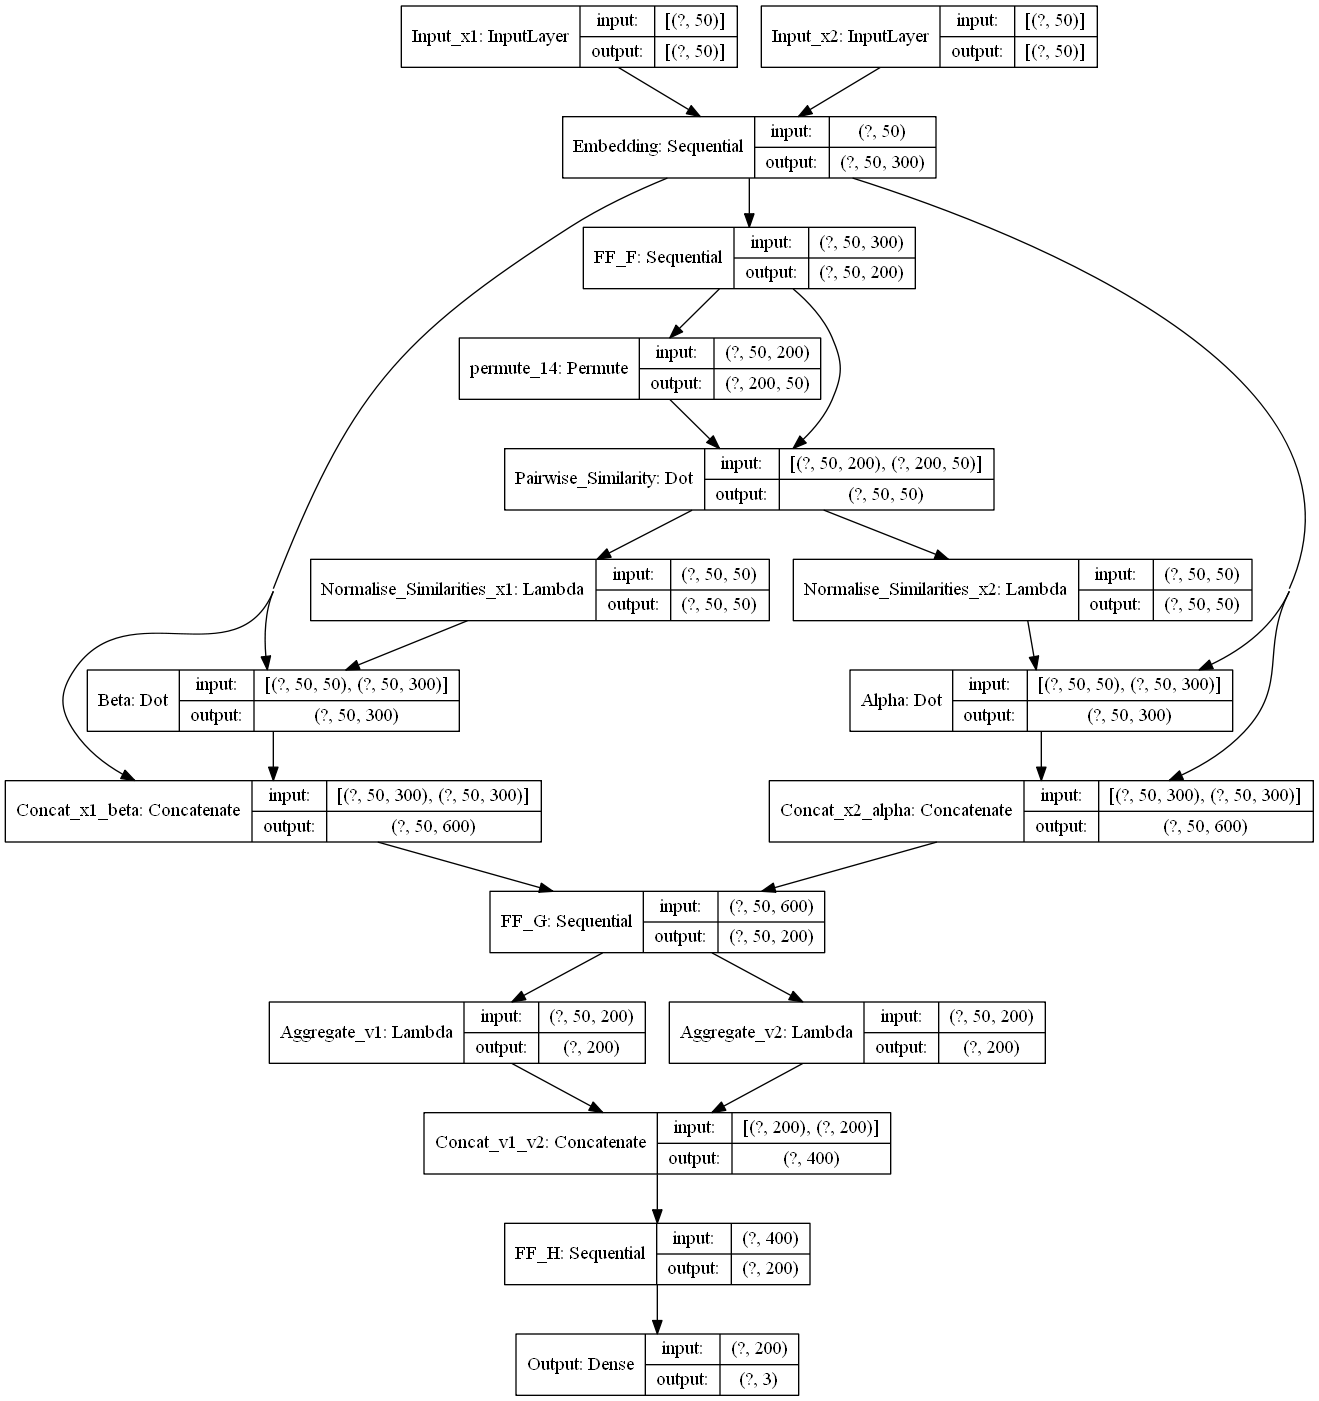

In [84]:
# Plot Model Architecture
tf.keras.utils.plot_model(dam_model, to_file=model_representations_dir+'/dam_model.png', show_shapes=True, show_layer_names=True)

### Decomposable Attention Model with Intra-Sentence Attention (DAM-INTRA)

In [48]:
dam_intra_model = build_dam_model(200, intra_sentence_attention=True)
dam_intra_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_x1 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
Input_x2 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
Embedding (Sequential)          (None, 50, 300)      10873200    Input_x1[0][0]                   
                                                                 Input_x2[0][0]                   
__________________________________________________________________________________________________
FF_Intra (Sequential)           (None, 50, 200)      100400      Embedding[1][0]            

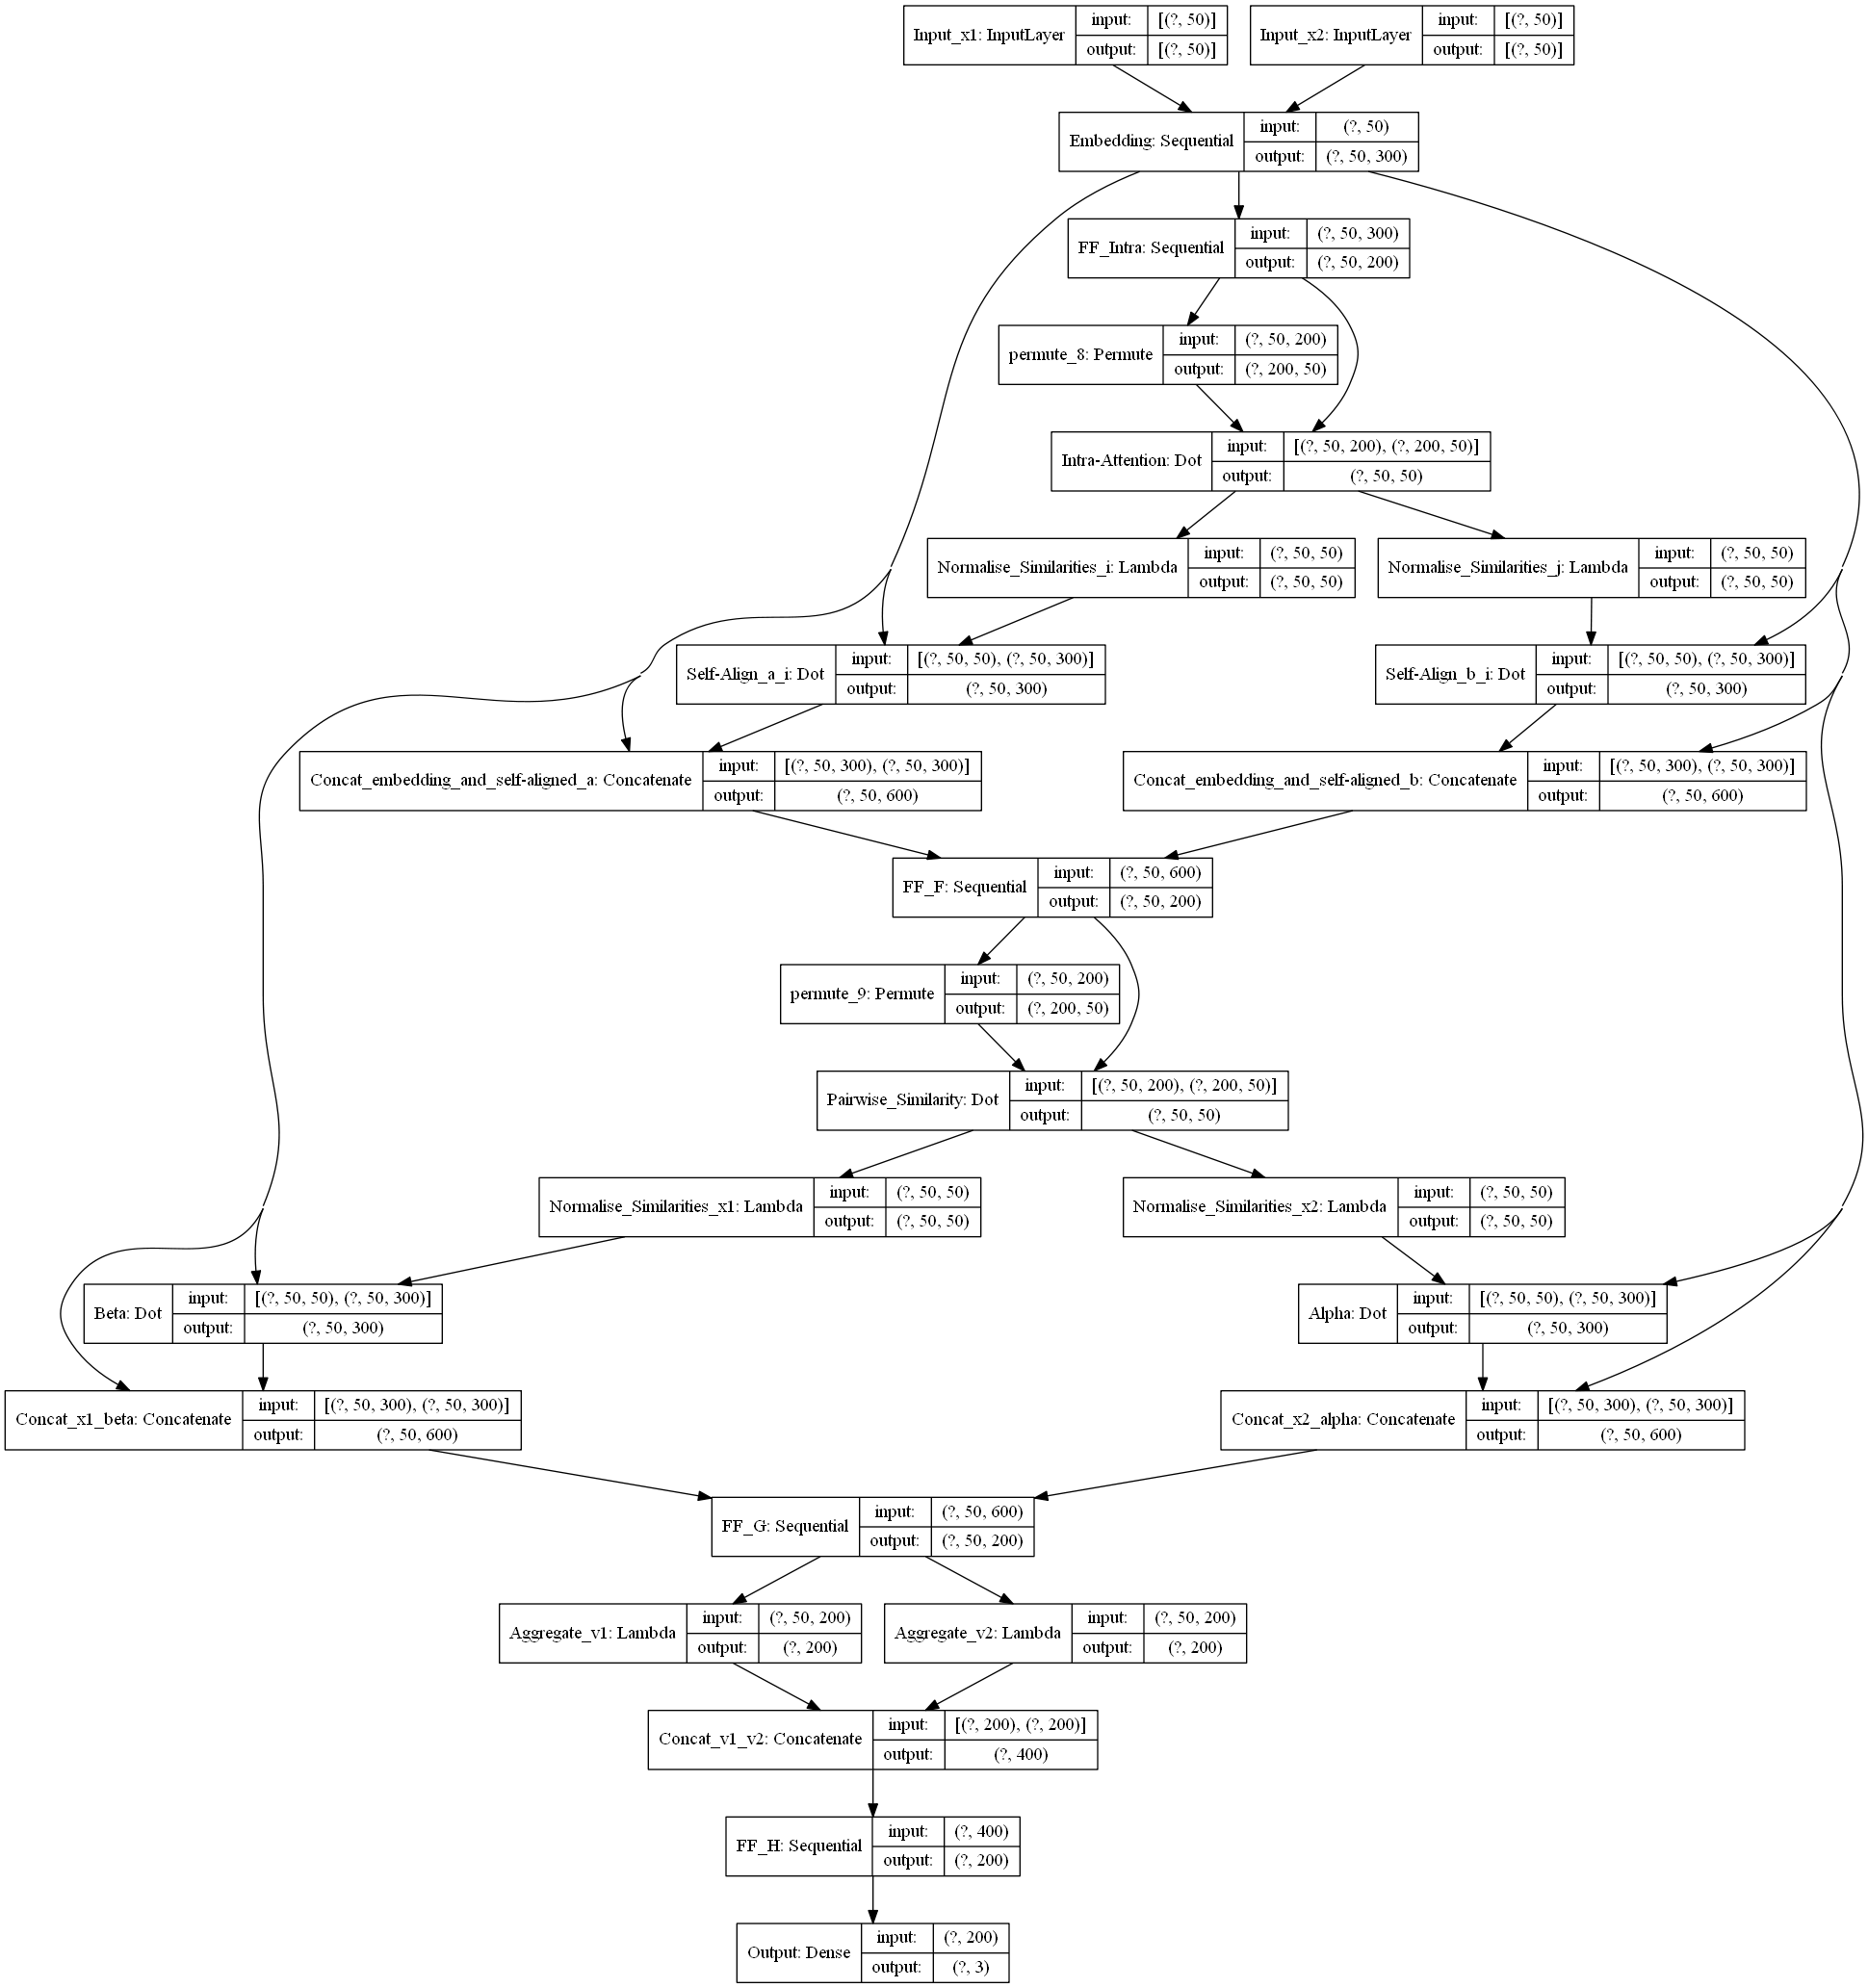

In [49]:
# Plot Model Architecture
tf.keras.utils.plot_model(dam_intra_model, to_file=model_representations_dir+'/dam_intra_model.png', show_shapes=True, show_layer_names=True)

### Decomposable Attention Model with BiLSTM. (DAM-BiLSTM)

In [54]:
# Function to combine layers together and return the final dam_bilstm model
def build_dam_bilstm_model(num_nodes):
      
    # Input Layer
    x1 = layers.Input(shape=(max_sequence_len,), name="Input_x1")
    x2 = layers.Input(shape=(max_sequence_len,), name="Input_x2")
    
    # Embedding Layer
    embedding = embedding_layer("Embedding", embeddings)
    e1 = embedding(x1)
    e2 = embedding(x2)
        
    # Attend
    # -> Pass each word through a FFN with RelU activations to yield a non-linear transformation.
    feedforward_F = feed_forward_layer("FF_F", num_nodes, dropout_rate= 0.1)
    x1_nonlinear = feedforward_F(e1)
    x2_nonlinear = feedforward_F(e2)
    
    # -> Compute pairwise word similarity between every word in x1 compared to every word in x2, and vice versa.
    vector_similarities = layers.dot([x1_nonlinear, layers.Permute((2,1))(x2_nonlinear)], axes=(2,1), name="Pairwise_Similarity")
    
    # -> Compute Soft-Attention
    norm_similarities_x1 = layers.Lambda(normalizer(1), name="Normalise_Similarities_x1")(vector_similarities)
    norm_similarities_x2 = layers.Lambda(normalizer(2), name="Normalise_Similarities_x2")(vector_similarities)
    alpha = layers.dot([norm_similarities_x2, e1], axes=1, name="Alpha")
    beta = layers.dot([norm_similarities_x1, e2], axes=1, name="Beta")
        
    # Compare
    comp1 = layers.concatenate([e1, beta], name="Concat_x1_beta")
    comp2 = layers.concatenate([e2, alpha], name="Concat_x2_alpha")
    
    # BiLSTM_G isntead of FFN_G
    bilstm_G = bilstm_layer("BiLSTM_G", num_nodes=num_nodes, dropout_rate= 0)
    v1 = bilstm_G(comp1)
    v2 = bilstm_G(comp2)
    
    # Aggregate
    v1_sum = layers.Lambda(aggregater, name="Aggregate_v1")(v1)
    v2_sum = layers.Lambda(aggregater, name="Aggregate_v2")(v2)
    concat = layers.concatenate([v1_sum, v2_sum], name="Concat_v1_v2")
    
    # Output Layer
    feedforward_H = feed_forward_layer("FF_H", num_nodes, dropout_rate= 0.1)
    y = feedforward_H(concat)
    y = layers.Dense(3, activation="softmax", name="Output")(y)
        
    model = Model(inputs=[x1, x2], outputs=y)
    
    model.compile(
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
        optimizer=Adam(lr=0.0005),
    )

    return model

In [56]:
dam_bilstm_model = build_dam_bilstm_model(200)
dam_bilstm_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_x1 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
Input_x2 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
Embedding (Sequential)          (None, 50, 300)      10873200    Input_x1[0][0]                   
                                                                 Input_x2[0][0]                   
__________________________________________________________________________________________________
FF_F (Sequential)               (None, 50, 200)      100400      Embedding[1][0]            

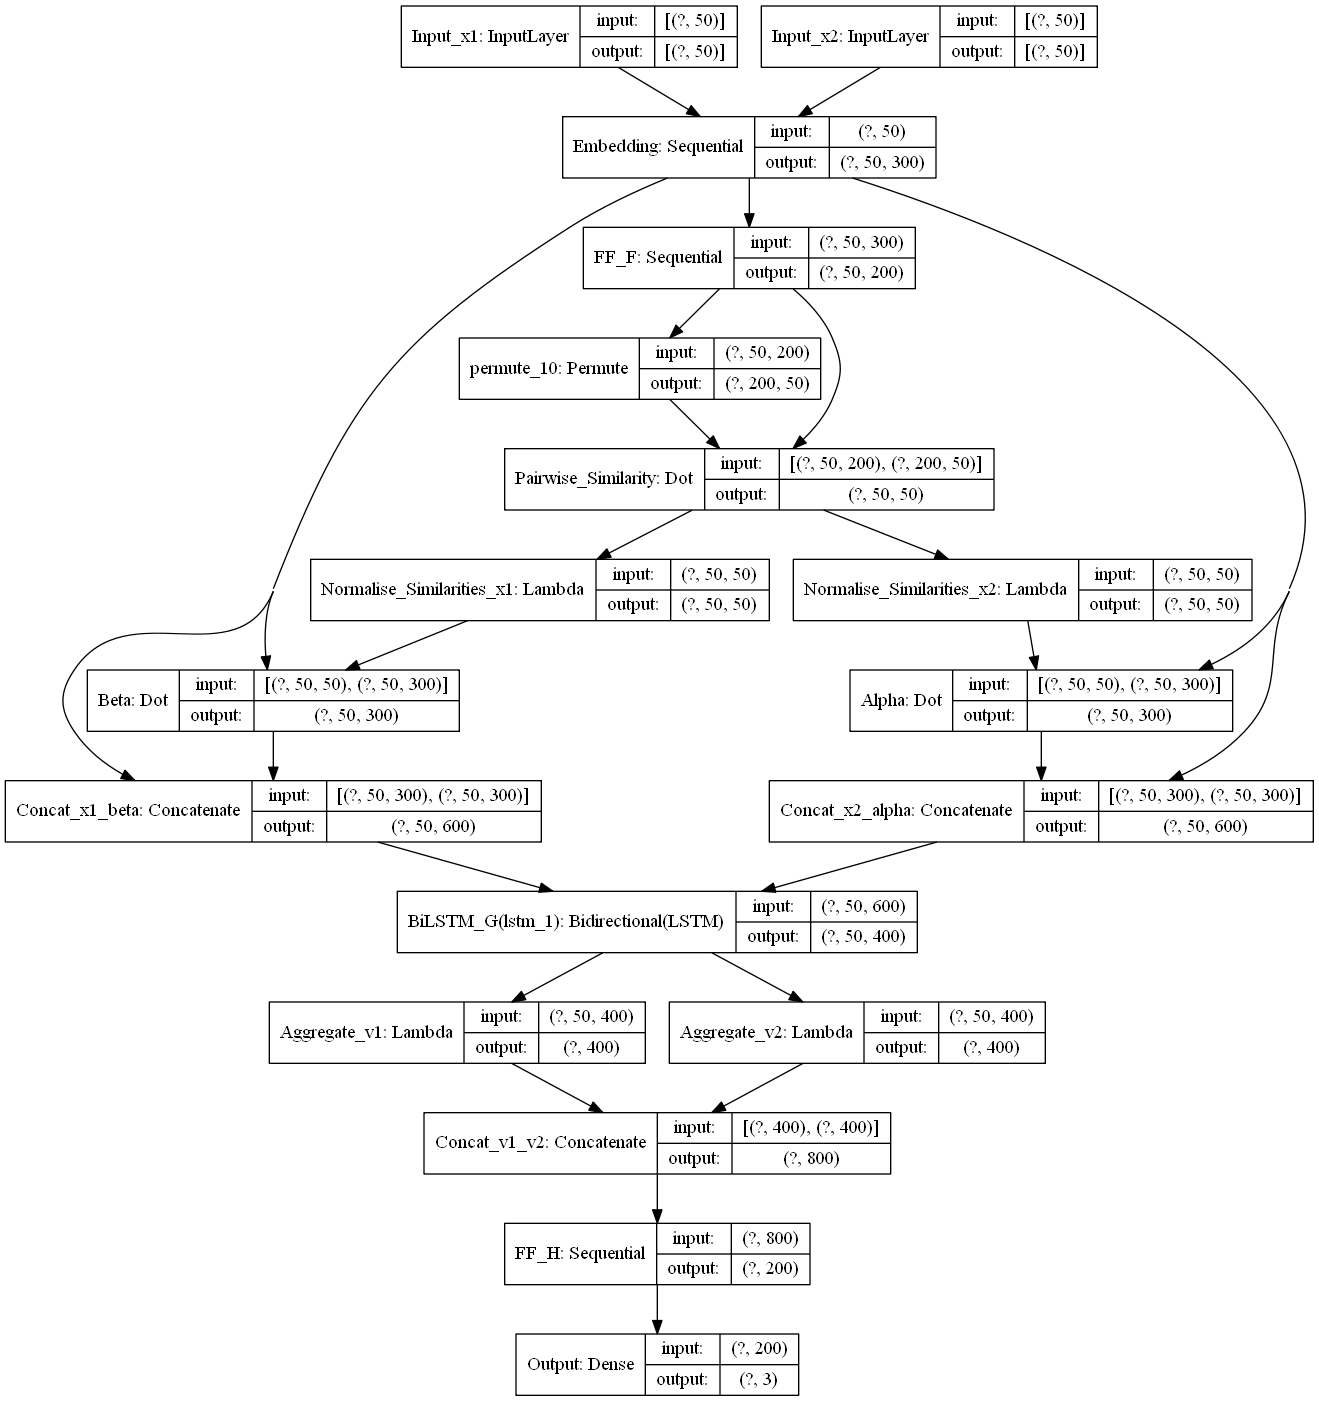

In [57]:
# Plot Model Architecture
tf.keras.utils.plot_model(dam_bilstm_model, to_file=model_representations_dir+'/dam_bilstm_model.png', show_shapes=True, show_layer_names=True)

### Decomposable Attention Model with BiGRU. (DAM-BiGRU)

In [75]:
# Function to combine layers together and return the final dam_bigru model
def build_dam_bigru_model(num_nodes):
      
    # Input Layer
    x1 = layers.Input(shape=(max_sequence_len,), name="Input_x1")
    x2 = layers.Input(shape=(max_sequence_len,), name="Input_x2")
    
    # Embedding Layer
    embedding = embedding_layer("Embedding", embeddings)
    e1 = embedding(x1)
    e2 = embedding(x2)
        
    # Attend
    # -> Pass each word through a FFN with RelU activations to yield a non-linear transformation.
    feedforward_F = feed_forward_layer("FF_F", num_nodes, dropout_rate= 0.1)
    x1_nonlinear = feedforward_F(e1)
    x2_nonlinear = feedforward_F(e2)
    
    # -> Compute pairwise word similarity between every word in x1 compared to every word in x2, and vice versa.
    vector_similarities = layers.dot([x1_nonlinear, layers.Permute((2,1))(x2_nonlinear)], axes=(2,1), name="Pairwise_Similarity")
    
    # -> Compute Soft-Attention
    norm_similarities_x1 = layers.Lambda(normalizer(1), name="Normalise_Similarities_x1")(vector_similarities)
    norm_similarities_x2 = layers.Lambda(normalizer(2), name="Normalise_Similarities_x2")(vector_similarities)
    alpha = layers.dot([norm_similarities_x2, e1], axes=1, name="Alpha")
    beta = layers.dot([norm_similarities_x1, e2], axes=1, name="Beta")
        
    # Compare
    comp1 = layers.concatenate([e1, beta], name="Concat_x1_beta")
    comp2 = layers.concatenate([e2, alpha], name="Concat_x2_alpha")
    
    # BiGRU_G isntead of FFN_G
    bigru_G = bigru_layer("BiGRU_G", num_nodes=num_nodes, dropout_rate= 0)
    v1 = bigru_G(comp1)
    v2 = bigru_G(comp2)
    
    # Aggregate
    v1_sum = layers.Lambda(aggregater, name="Aggregate_v1")(v1)
    v2_sum = layers.Lambda(aggregater, name="Aggregate_v2")(v2)
    concat = layers.concatenate([v1_sum, v2_sum], name="Concat_v1_v2")
    
    # Output Layer
    feedforward_H = feed_forward_layer("FF_H", num_nodes, dropout_rate= 0.1)
    y = feedforward_H(concat)
    y = layers.Dense(3, activation="softmax", name="Output")(y)
        
    model = Model(inputs=[x1, x2], outputs=y)
    
    model.compile(
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
        optimizer=Adam(lr=0.0005),
    )

    return model

In [76]:
dam_bigru_model = build_dam_bigru_model(200)
dam_bigru_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_x1 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
Input_x2 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
Embedding (Sequential)          (None, 50, 300)      10873200    Input_x1[0][0]                   
                                                                 Input_x2[0][0]                   
__________________________________________________________________________________________________
FF_F (Sequential)               (None, 50, 200)      100400      Embedding[1][0]           

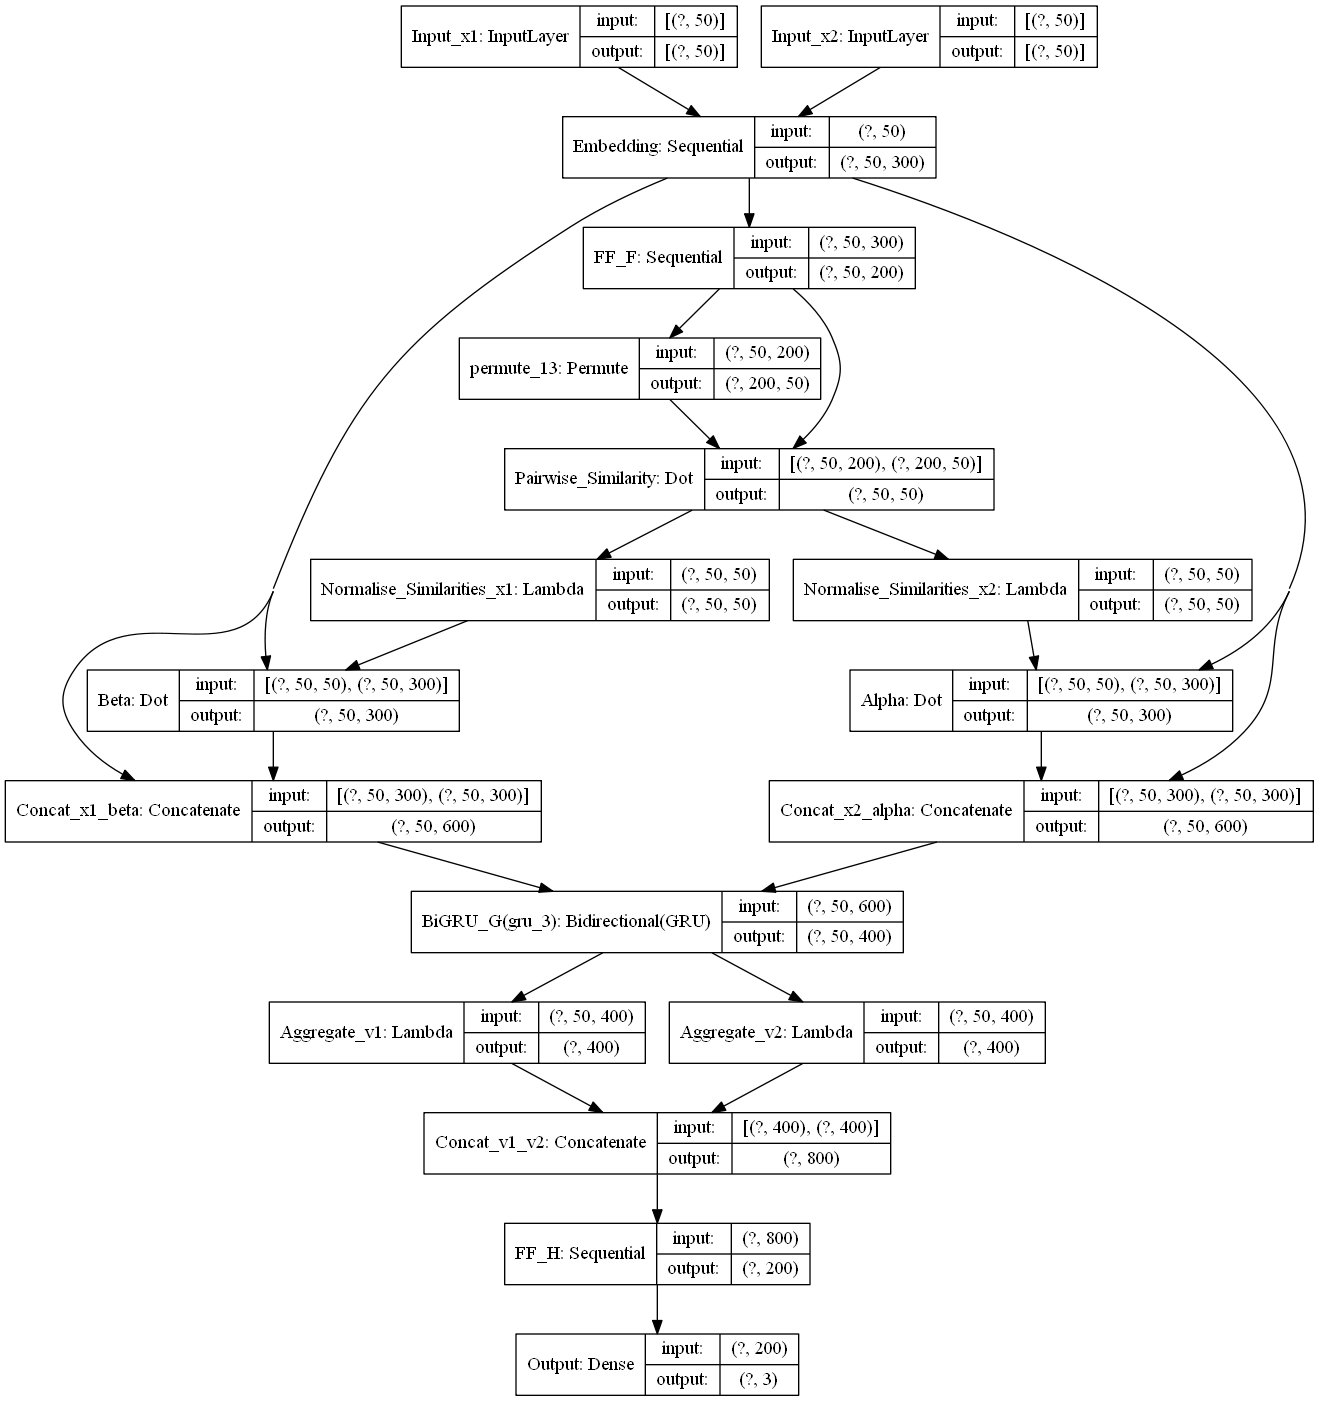

In [77]:
# Plot Model Architecture
tf.keras.utils.plot_model(dam_bigru_model, to_file=model_representations_dir+'/dam_bigru_model.png', show_shapes=True, show_layer_names=True)

# 4. Model Training

In [70]:
# If saved models directory doesn't exist, create it
if not os.path.exists(saved_models_dir):
    os.mkdir(saved_models_dir)

In [71]:
# Train the model and if the validation loss did not improve after 5 times, stop training
#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience = 5)
monitor = EarlyStopping(monitor='val_loss', patience = 5)

# Store best weights after stopping with the lowest validation error
dam_checkpointer = ModelCheckpoint(filepath=dam_save_file, save_best_only=True)
dam_intra_checkpointer = ModelCheckpoint(filepath=dam_intra_save_file, save_best_only=True)
dam_bilstm_checkpointer = ModelCheckpoint(filepath=dam_bilstm_save_file, save_best_only=True)
dam_bigru_checkpointer = ModelCheckpoint(filepath=dam_bigru_save_file, save_best_only=True)

In [72]:
# Model Training Inputs
t_1 = train_sequence_dict['premise_padded']
t_2 = train_sequence_dict['hypothesis_padded']
t_y = train_df['label_index']

# Model Validation Inputs
v_1 = val_sequence_dict['premise_padded']
v_2 = val_sequence_dict['hypothesis_padded']
v_y = val_df['label_index']

### Decomposable Attention Model by Perikh et al. (DAM)

In [30]:
# Optimiser information
dam_model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.0005,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [31]:
# Train DAM model
trained_dam_model = dam_model.fit(
    [t_1, t_2], t_y,
    validation_data=([v_1, v_2], v_y),
    callbacks=[monitor, dam_checkpointer],
    batch_size=512,
    epochs=50,
)

Train on 549367 samples, validate on 9842 samples
Epoch 1/50
549367/549367 [==============================] - 61s 111us/sample - loss: 0.7171 - accuracy: 0.6871 - val_loss: 0.5219 - val_accuracy: 0.7968
Epoch 2/50
549367/549367 [==============================] - 59s 107us/sample - loss: 0.5511 - accuracy: 0.7807 - val_loss: 0.4834 - val_accuracy: 0.8121
Epoch 3/50
549367/549367 [==============================] - 60s 110us/sample - loss: 0.5117 - accuracy: 0.7981 - val_loss: 0.4541 - val_accuracy: 0.8207
Epoch 4/50
549367/549367 [==============================] - 57s 105us/sample - loss: 0.4870 - accuracy: 0.8093 - val_loss: 0.4375 - val_accuracy: 0.8290
Epoch 5/50
549367/549367 [==============================] - 57s 105us/sample - loss: 0.4699 - accuracy: 0.8166 - val_loss: 0.4368 - val_accuracy: 0.8310
Epoch 6/50
549367/549367 [==============================] - 63s 114us/sample - loss: 0.4563 - accuracy: 0.8227 - val_loss: 0.4265 - val_accuracy: 0.8350
Epoch 7/50
549367/549367 [======

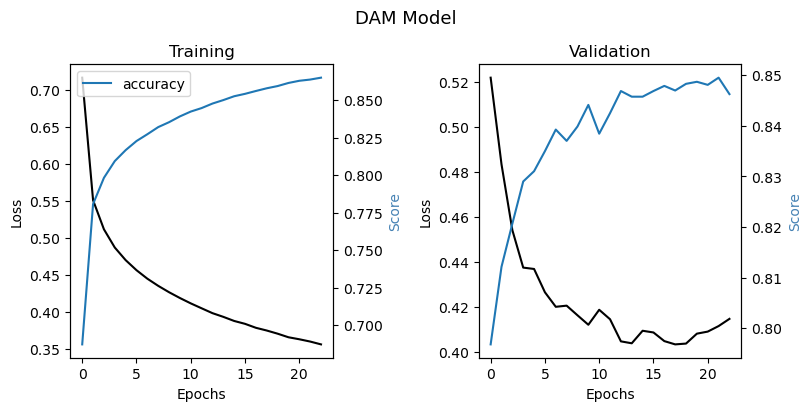

In [32]:
metrics = [k for k in trained_dam_model.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(8,4), dpi= 100)
fig.suptitle("DAM Model", fontsize=13)

ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(trained_dam_model.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(trained_dam_model.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()

ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(trained_dam_model.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(trained_dam_model.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

### Decomposable Attention Model with Intra-Sentence Attention. (DAM-INTRA)

In [46]:
# Optimiser information
dam_intra_model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.0005,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [50]:
# Train DAM Intra model
trained_dam_intra_model = dam_intra_model.fit(
    [t_1, t_2], t_y,
    validation_data=([v_1, v_2], v_y),
    callbacks=[monitor, dam_intra_checkpointer],
    batch_size=512,
    epochs=50,
)

Train on 549367 samples, validate on 9842 samples
Epoch 1/50
549367/549367 [==============================] - 87s 159us/sample - loss: 0.7320 - accuracy: 0.6778 - val_loss: 0.5249 - val_accuracy: 0.7921
Epoch 2/50
549367/549367 [==============================] - 86s 156us/sample - loss: 0.5547 - accuracy: 0.7778 - val_loss: 0.4753 - val_accuracy: 0.8118
Epoch 3/50
549367/549367 [==============================] - 86s 156us/sample - loss: 0.5133 - accuracy: 0.7975 - val_loss: 0.4519 - val_accuracy: 0.8224
Epoch 4/50
549367/549367 [==============================] - 89s 162us/sample - loss: 0.4888 - accuracy: 0.8083 - val_loss: 0.4450 - val_accuracy: 0.8274
Epoch 5/50
549367/549367 [==============================] - 94s 172us/sample - loss: 0.4703 - accuracy: 0.8164 - val_loss: 0.4321 - val_accuracy: 0.8332
Epoch 6/50
549367/549367 [==============================] - 93s 170us/sample - loss: 0.4558 - accuracy: 0.8229 - val_loss: 0.4246 - val_accuracy: 0.8368
Epoch 7/50
549367/549367 [======

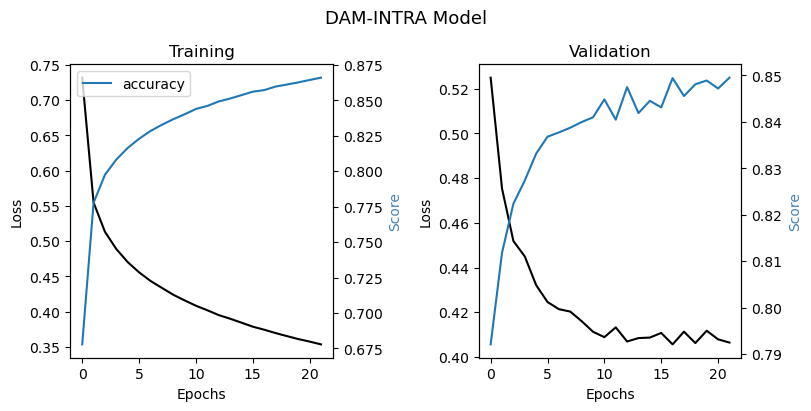

In [64]:
metrics = [k for k in trained_dam_intra_model.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(8,4), dpi= 100)
fig.suptitle("DAM-INTRA Model", fontsize=13)

ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(trained_dam_intra_model.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(trained_dam_intra_model.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()

ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(trained_dam_intra_model.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(trained_dam_intra_model.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

### Decomposable Attention Model with BiLSTM. (DAM-BiLSTM)

In [65]:
# Optimiser information
dam_bilstm_model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.0005,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [66]:
# Train DAM BiLSTM model
trained_dam_bilstm_model = dam_bilstm_model.fit(
    [t_1, t_2], t_y,
    validation_data=([v_1, v_2], v_y),
    callbacks=[monitor, dam_bilstm_checkpointer],
    batch_size=512,
    epochs=50,
)

Train on 549367 samples, validate on 9842 samples
Epoch 1/50
549367/549367 [==============================] - 224s 408us/sample - loss: 0.6759 - accuracy: 0.7099 - val_loss: 0.4972 - val_accuracy: 0.8030
Epoch 2/50
549367/549367 [==============================] - 223s 405us/sample - loss: 0.5159 - accuracy: 0.7955 - val_loss: 0.4492 - val_accuracy: 0.8219
Epoch 3/50
549367/549367 [==============================] - 222s 404us/sample - loss: 0.4712 - accuracy: 0.8154 - val_loss: 0.4258 - val_accuracy: 0.8383
Epoch 4/50
549367/549367 [==============================] - 225s 410us/sample - loss: 0.4392 - accuracy: 0.8303 - val_loss: 0.4212 - val_accuracy: 0.8394
Epoch 5/50
549367/549367 [==============================] - 225s 410us/sample - loss: 0.4136 - accuracy: 0.8416 - val_loss: 0.4043 - val_accuracy: 0.8440
Epoch 6/50
549367/549367 [==============================] - 227s 413us/sample - loss: 0.3924 - accuracy: 0.8501 - val_loss: 0.4027 - val_accuracy: 0.8495
Epoch 7/50
549367/549367 [

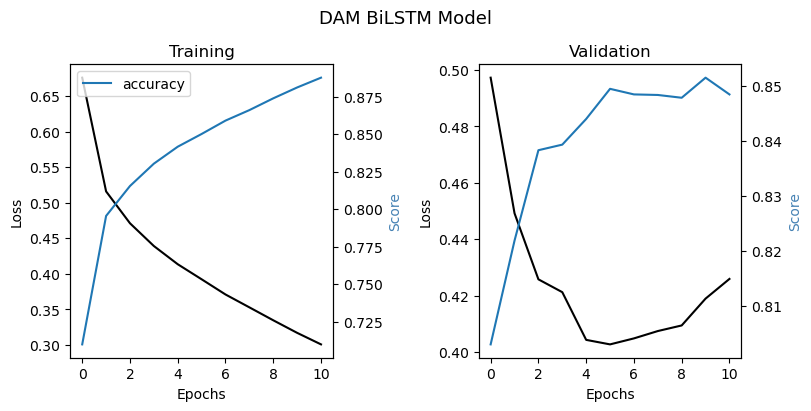

In [85]:
metrics = [k for k in trained_dam_bilstm_model.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(8,4), dpi= 100)
fig.suptitle("DAM BiLSTM Model", fontsize=13)

ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(trained_dam_bilstm_model.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(trained_dam_bilstm_model.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()

ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(trained_dam_bilstm_model.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(trained_dam_bilstm_model.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

### Decomposable Attention Model with BiGRU. (DAM-BiGRU)

In [78]:
# Optimiser information
dam_bigru_model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.0005,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [79]:
# Train DAM BiGRU model
trained_dam_bigru_model = dam_bigru_model.fit(
    [t_1, t_2], t_y,
    validation_data=([v_1, v_2], v_y),
    callbacks=[monitor, dam_bigru_checkpointer],
    batch_size=512,
    epochs=50,
)

Train on 549367 samples, validate on 9842 samples
Epoch 1/50
549367/549367 [==============================] - 224s 408us/sample - loss: 0.6781 - accuracy: 0.7084 - val_loss: 0.4988 - val_accuracy: 0.8059
Epoch 2/50
549367/549367 [==============================] - 218s 397us/sample - loss: 0.5173 - accuracy: 0.7947 - val_loss: 0.4495 - val_accuracy: 0.8235
Epoch 3/50
549367/549367 [==============================] - 221s 403us/sample - loss: 0.4714 - accuracy: 0.8156 - val_loss: 0.4293 - val_accuracy: 0.8360
Epoch 4/50
549367/549367 [==============================] - 224s 409us/sample - loss: 0.4402 - accuracy: 0.8298 - val_loss: 0.4155 - val_accuracy: 0.8419
Epoch 5/50
549367/549367 [==============================] - 220s 401us/sample - loss: 0.4155 - accuracy: 0.8407 - val_loss: 0.4053 - val_accuracy: 0.8484
Epoch 6/50
549367/549367 [==============================] - 217s 396us/sample - loss: 0.3947 - accuracy: 0.8493 - val_loss: 0.3975 - val_accuracy: 0.8506
Epoch 7/50
549367/549367 [

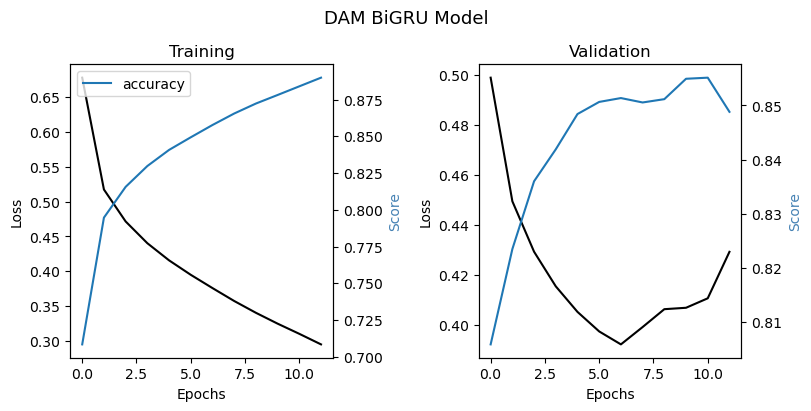

In [81]:
metrics = [k for k in trained_dam_bigru_model.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(8,4), dpi= 100)
fig.suptitle("DAM BiGRU Model", fontsize=13)

ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(trained_dam_bigru_model.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(trained_dam_bigru_model.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()

ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(trained_dam_bigru_model.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(trained_dam_bigru_model.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()